In [82]:
import matplotlib.pyplot as plt
from astropy.io import fits
import pandas as pd, numpy as np, os, keras
from numpy import asarray
from PIL import Image
from keras.preprocessing.image import load_img
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.models import Sequential
from keras.layers import (Conv2D, MaxPooling2D, UpSampling2D, Dense, Flatten, Reshape, Dropout, InputLayer, Input)
from keras.models import Model
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.cluster import KMeans

#clear keras backend
#keras.backend.clear_session()

In [2]:
def create_dataset(img_folder):
    #from PIL import Image
    from keras.preprocessing import image
    img_data_array=[]
    diff=[]
    for i, file in enumerate(os.listdir(img_folder)):
        if '.png' in file:
            img = image.load_img(img_folder+'/'+file, target_size=(232,232,1))
            img = image.img_to_array(img)
            img /= 255
            if 'diff' in file: diff.append(img)
            img_data_array.append(img)

    return img_data_array

def adjust_spines(ax, spines):
    for loc, spine in ax.spines.items():
        if loc in spines:
            spine.set_position(('outward', 0))  # outward by 0 points
        else:
            spine.set_color('none')  # don't draw spine

    # turn off ticks where there is no spine
    if 'left' in spines:
        ax.yaxis.set_ticks_position('left')
    else:
        # no yaxis ticks
        ax.yaxis.set_ticks([])

    if 'bottom' in spines:
        ax.xaxis.set_ticks_position('bottom')
    else:
        # no xaxis ticks
        ax.xaxis.set_ticks([])

from SDSSRM_11_Pix_Filter_Trevor import pixel_filter
plt.rcParams['axes.xmargin'] = 0 #turn off whitespace in plots

In [3]:
PIL_img_data = create_dataset("spectra")
training_data = np.array(PIL_img_data)
training_data.shape


(1200, 232, 232, 3)

[ 503  882 1081  941  127  687  188  874  277  247]


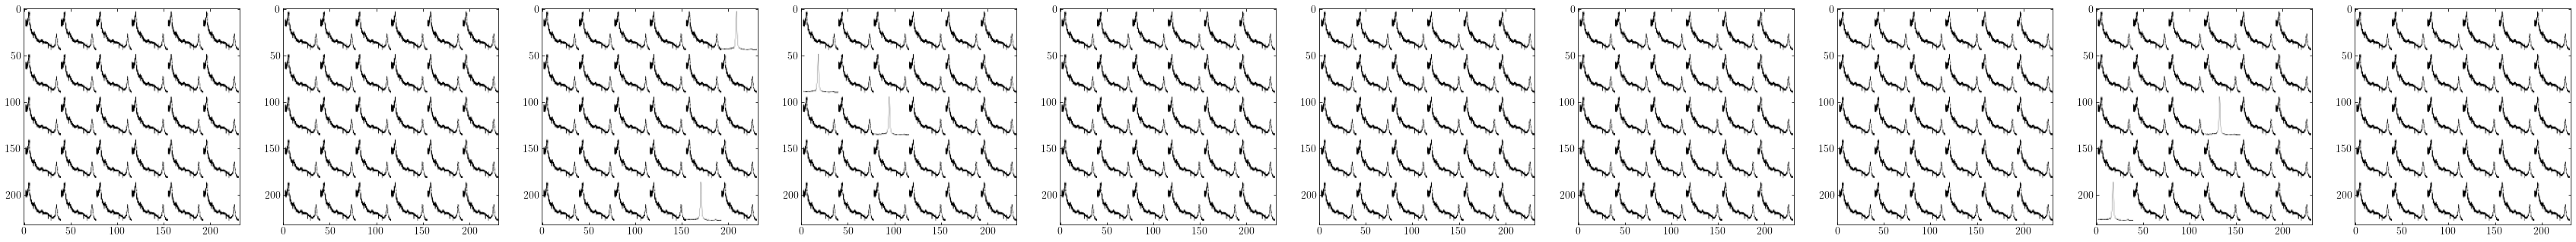

In [165]:
# img = Image.open('test_diff_2.png')
# print(img.size)
# img = np.array(img)
# resized = img.astype('float32')
# resized /= 255
# print(resized.shape)
# plt.imshow(resized)

idx = np.random.choice(len(training_data), size=10) 
print(idx)
fig, ax = plt.subplots(ncols=10, figsize=(60,20))
for i, num in enumerate(idx):
    ax[i].imshow(training_data[num], cmap='gray')
plt.show()

In [4]:
earlystop = EarlyStopping(
    monitor="val_loss",
    min_delta=0,
    patience=20,
    verbose=0,
    mode="auto",
    baseline=None,
    restore_best_weights=True)

checkpoint_path = "training_1/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create a callback that saves the model's weights
checkpoints = ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)

#split data
X_train,X_test,X_train,X_test = train_test_split(training_data, training_data,
                                                             test_size=0.2, random_state=13, 
                                                             shuffle=True)

In [233]:
print(len(X_train))
print(len(X_test))

960
240


In [14]:
# def build_autoencoder(img_size):
#     encoder = Sequential([
#         InputLayer(input_shape=img_size),
#         Conv2D(filters=64, kernel_size=3, activation='relu', padding='same'),
#         MaxPooling2D(pool_size=2), 
#         Conv2D(128, 3, activation='relu', padding='same'),
#         MaxPooling2D(pool_size=2),
#         Conv2D(256, 3, activation='relu', padding='same'),
#         MaxPooling2D(pool_size=2),
#     ])
    
#     decoder = Sequential([
#         Conv2D(256, 3, activation='relu', padding='same'),
#         UpSampling2D(2),
#         Conv2D(128, 3, activation='relu', padding='same'),
#         UpSampling2D(2),
#         Conv2D(64, 3, activation='relu', padding='same'),
#         UpSampling2D(2),
#         Conv2D(1, 3, activation='sigmoid', padding='same'),
#         Reshape((img_size[0], img_size[1], 1))
#     ])

#     return encoder, decoder

# def build_autoencoder(img_size):
#     #ENCODER
#     inp = Input((28, 28,1))
#     e = Conv2D(32, (3, 3), activation='relu')(inp)
#     e = MaxPooling2D((2, 2))(e)
#     e = Conv2D(64, (3, 3), activation='relu')(e)
#     e = MaxPooling2D((2, 2))(e)
#     e = Conv2D(64, (3, 3), activation='relu')(e)
#     l = Flatten()(e)
#     l = Dense(49, activation='softmax')(l)
#     #DECODER
#     d = Reshape((7,7,1))(l)
#     d = Conv2DTranspose(64,(3, 3), strides=2, activation='relu', padding='same')(d)
#     d = BatchNormalization()(d)
#     d = Conv2DTranspose(64,(3, 3), strides=2, activation='relu', padding='same')(d)
#     d = BatchNormalization()(d)
#     d = Conv2DTranspose(32,(3, 3), activation='relu', padding='same')(d)
#     decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(d)
#     ae = Model(inp, decoded)
#     ae.summary()


# #original version 
input_img = Input(shape=(232, 232, 3), name="input")
code_size=32
#ENCODER
enc_conv1 = Conv2D(12, (3, 3), activation='relu', padding='same')(input_img)
enc_pool1 = MaxPooling2D((2, 2), padding='same')(enc_conv1)
enc_conv2 = Conv2D(8, (4, 4), activation='relu', padding='same')(enc_pool1)
enc_output = MaxPooling2D((4, 4), padding='same')(enc_conv2)
enc_flatten = Flatten()(enc_output)
bottleneck = Dense(code_size, activation="relu", name='bottleneck')(enc_flatten)

#DECODER
dec_dense = Dense(6728)(bottleneck)
dec_reshape = Reshape((29,29,8))(dec_dense)
dec_conv2 = Conv2D(8, (4, 4), activation='relu', padding='same')(dec_reshape)
dec_upsample2 = UpSampling2D((4, 4))(dec_conv2)
dec_conv3 = Conv2D(12, (3, 3), activation='relu', padding='same')(dec_upsample2)
dec_upsample3 = UpSampling2D((2, 2))(dec_conv3)
dec_output = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(dec_upsample3)

#build autoencoder
autoencoder = Model(input_img, dec_output, name='autoencoder')
autoencoder.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])
autoencoder.summary()

#build encoder
encoder = Model(input_img, bottleneck, name='encoder')
encoder.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])
encoder.summary()

# def build_autoencoder(img_size):
#     encoder = Sequential()
#     encoder.add(InputLayer(img_shape))
#     encoder.add(Flatten())
#     encoder.add(Dense(code_size))

#     # The decoder
#     decoder = Sequential()
#     decoder.add(InputLayer((code_size,)))
#     decoder.add(Dense(np.prod(img_shape))) # np.prod(img_shape) is the same as 32*32*3, it's more generic than saying 3072
#     decoder.add(Reshape(img_shape))



Model: "autoencoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 232, 232, 3)]     0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 232, 232, 12)      336       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 116, 116, 12)      0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 116, 116, 8)       1544      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 29, 29, 8)         0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 6728)              0         
_________________________________________________________________
bottleneck (Dense)           (None, 32)                

In [6]:
#combine into autoencoder
autoencoder = Sequential([encoder, decoder])
autoencoder.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])
    
    #loss="mean_squared_error", optimizer="RMSprop", metrics=['accuracy'])

NameError: name 'encoder' is not defined

In [ ]:
# or load old model
autoencoder = Sequential([encoder, decoder])
autoencoder.load_weights(checkpoint_path)

Epoch 1/500
30/30 [==============================] - 38s 1s/step - loss: 0.2513 - accuracy: 0.2031 - val_loss: 0.1677 - val_accuracy: 0.2459
Epoch 2/500
30/30 [==============================] - 37s 1s/step - loss: 0.1575 - accuracy: 0.2505 - val_loss: 0.1485 - val_accuracy: 0.2539
Epoch 3/500
30/30 [==============================] - 37s 1s/step - loss: 0.1427 - accuracy: 0.2712 - val_loss: 0.1366 - val_accuracy: 0.2830
Epoch 4/500
30/30 [==============================] - 37s 1s/step - loss: 0.1341 - accuracy: 0.2943 - val_loss: 0.1301 - val_accuracy: 0.3049
Epoch 5/500
30/30 [==============================] - 37s 1s/step - loss: 0.1284 - accuracy: 0.3197 - val_loss: 0.1252 - val_accuracy: 0.3326
Epoch 6/500
30/30 [==============================] - 37s 1s/step - loss: 0.1235 - accuracy: 0.3437 - val_loss: 0.1209 - val_accuracy: 0.3524
Epoch 7/500
30/30 [==============================] - 37s 1s/step - loss: 0.1200 - accuracy: 0.3585 - val_loss: 0.1179 - val_accuracy: 0.3609
Epoch 8/500
3

Epoch 59/500
30/30 [==============================] - 37s 1s/step - loss: 0.0850 - accuracy: 0.2672 - val_loss: 0.0868 - val_accuracy: 0.2670
Epoch 60/500
30/30 [==============================] - 37s 1s/step - loss: 0.0847 - accuracy: 0.2683 - val_loss: 0.0841 - val_accuracy: 0.2642
Epoch 61/500
30/30 [==============================] - 36s 1s/step - loss: 0.0847 - accuracy: 0.2686 - val_loss: 0.0841 - val_accuracy: 0.2645
Epoch 62/500
30/30 [==============================] - 37s 1s/step - loss: 0.0844 - accuracy: 0.2683 - val_loss: 0.0839 - val_accuracy: 0.2649
Epoch 63/500
30/30 [==============================] - 37s 1s/step - loss: 0.0842 - accuracy: 0.2680 - val_loss: 0.0848 - val_accuracy: 0.2653
Epoch 64/500
30/30 [==============================] - 37s 1s/step - loss: 0.0842 - accuracy: 0.2683 - val_loss: 0.0836 - val_accuracy: 0.2663
Epoch 65/500
30/30 [==============================] - 37s 1s/step - loss: 0.0839 - accuracy: 0.2687 - val_loss: 0.0842 - val_accuracy: 0.2663
Epoch 

30/30 [==============================] - 37s 1s/step - loss: 0.0781 - accuracy: 0.3662 - val_loss: 0.0783 - val_accuracy: 0.3658
Epoch 117/500
30/30 [==============================] - 37s 1s/step - loss: 0.0779 - accuracy: 0.3677 - val_loss: 0.0780 - val_accuracy: 0.3676
Epoch 118/500
30/30 [==============================] - 37s 1s/step - loss: 0.0779 - accuracy: 0.3686 - val_loss: 0.0783 - val_accuracy: 0.3712
Epoch 119/500
30/30 [==============================] - 37s 1s/step - loss: 0.0777 - accuracy: 0.3703 - val_loss: 0.0786 - val_accuracy: 0.3712
Epoch 120/500
30/30 [==============================] - 37s 1s/step - loss: 0.0777 - accuracy: 0.3714 - val_loss: 0.0779 - val_accuracy: 0.3687
Epoch 121/500
30/30 [==============================] - 36s 1s/step - loss: 0.0775 - accuracy: 0.3722 - val_loss: 0.0774 - val_accuracy: 0.3717
Epoch 122/500
30/30 [==============================] - 37s 1s/step - loss: 0.0775 - accuracy: 0.3749 - val_loss: 0.0783 - val_accuracy: 0.3771
Epoch 123/500

30/30 [==============================] - 35s 1s/step - loss: 0.0744 - accuracy: 0.4361 - val_loss: 0.0752 - val_accuracy: 0.4385
Epoch 174/500
30/30 [==============================] - 35s 1s/step - loss: 0.0744 - accuracy: 0.4375 - val_loss: 0.0750 - val_accuracy: 0.4366
Epoch 175/500
30/30 [==============================] - 35s 1s/step - loss: 0.0744 - accuracy: 0.4392 - val_loss: 0.0754 - val_accuracy: 0.4426
Epoch 176/500
30/30 [==============================] - 35s 1s/step - loss: 0.0743 - accuracy: 0.4401 - val_loss: 0.0748 - val_accuracy: 0.4375
Epoch 177/500
30/30 [==============================] - 35s 1s/step - loss: 0.0742 - accuracy: 0.4404 - val_loss: 0.0755 - val_accuracy: 0.4460
Epoch 178/500
30/30 [==============================] - 35s 1s/step - loss: 0.0742 - accuracy: 0.4420 - val_loss: 0.0755 - val_accuracy: 0.4399
Epoch 179/500
30/30 [==============================] - 35s 1s/step - loss: 0.0742 - accuracy: 0.4428 - val_loss: 0.0755 - val_accuracy: 0.4479
Epoch 180/500

30/30 [==============================] - 35s 1s/step - loss: 0.0725 - accuracy: 0.4654 - val_loss: 0.0730 - val_accuracy: 0.4675
Epoch 231/500
30/30 [==============================] - 35s 1s/step - loss: 0.0724 - accuracy: 0.4660 - val_loss: 0.0729 - val_accuracy: 0.4658
Epoch 232/500
30/30 [==============================] - 35s 1s/step - loss: 0.0724 - accuracy: 0.4663 - val_loss: 0.0729 - val_accuracy: 0.4677
Epoch 233/500
30/30 [==============================] - 35s 1s/step - loss: 0.0724 - accuracy: 0.4668 - val_loss: 0.0732 - val_accuracy: 0.4674
Epoch 234/500
30/30 [==============================] - 35s 1s/step - loss: 0.0724 - accuracy: 0.4667 - val_loss: 0.0730 - val_accuracy: 0.4688
Epoch 235/500
30/30 [==============================] - 35s 1s/step - loss: 0.0723 - accuracy: 0.4675 - val_loss: 0.0736 - val_accuracy: 0.4685
Epoch 236/500
30/30 [==============================] - 36s 1s/step - loss: 0.0724 - accuracy: 0.4675 - val_loss: 0.0731 - val_accuracy: 0.4704
Epoch 237/500

30/30 [==============================] - 36s 1s/step - loss: 0.0710 - accuracy: 0.4934 - val_loss: 0.0715 - val_accuracy: 0.4928
Epoch 288/500
30/30 [==============================] - 36s 1s/step - loss: 0.0711 - accuracy: 0.4940 - val_loss: 0.0717 - val_accuracy: 0.4960
Epoch 289/500
30/30 [==============================] - 36s 1s/step - loss: 0.0710 - accuracy: 0.4949 - val_loss: 0.0718 - val_accuracy: 0.4934
Epoch 290/500
30/30 [==============================] - 36s 1s/step - loss: 0.0710 - accuracy: 0.4954 - val_loss: 0.0723 - val_accuracy: 0.5002
Epoch 291/500
30/30 [==============================] - 36s 1s/step - loss: 0.0709 - accuracy: 0.4960 - val_loss: 0.0725 - val_accuracy: 0.4961
Epoch 292/500
30/30 [==============================] - 36s 1s/step - loss: 0.0709 - accuracy: 0.4962 - val_loss: 0.0725 - val_accuracy: 0.5018
Epoch 293/500
30/30 [==============================] - 36s 1s/step - loss: 0.0709 - accuracy: 0.4971 - val_loss: 0.0723 - val_accuracy: 0.4985
Epoch 294/500

30/30 [==============================] - 36s 1s/step - loss: 0.0700 - accuracy: 0.5133 - val_loss: 0.0708 - val_accuracy: 0.5142
Epoch 345/500
30/30 [==============================] - 35s 1s/step - loss: 0.0700 - accuracy: 0.5135 - val_loss: 0.0708 - val_accuracy: 0.5158
Epoch 346/500
30/30 [==============================] - 36s 1s/step - loss: 0.0700 - accuracy: 0.5138 - val_loss: 0.0709 - val_accuracy: 0.5167
Epoch 347/500
30/30 [==============================] - 35s 1s/step - loss: 0.0700 - accuracy: 0.5141 - val_loss: 0.0705 - val_accuracy: 0.5152
Epoch 348/500
30/30 [==============================] - 36s 1s/step - loss: 0.0699 - accuracy: 0.5148 - val_loss: 0.0707 - val_accuracy: 0.5149
Epoch 349/500
30/30 [==============================] - 35s 1s/step - loss: 0.0700 - accuracy: 0.5145 - val_loss: 0.0707 - val_accuracy: 0.5167
Epoch 350/500
30/30 [==============================] - 36s 1s/step - loss: 0.0699 - accuracy: 0.5150 - val_loss: 0.0709 - val_accuracy: 0.5164
Epoch 351/500

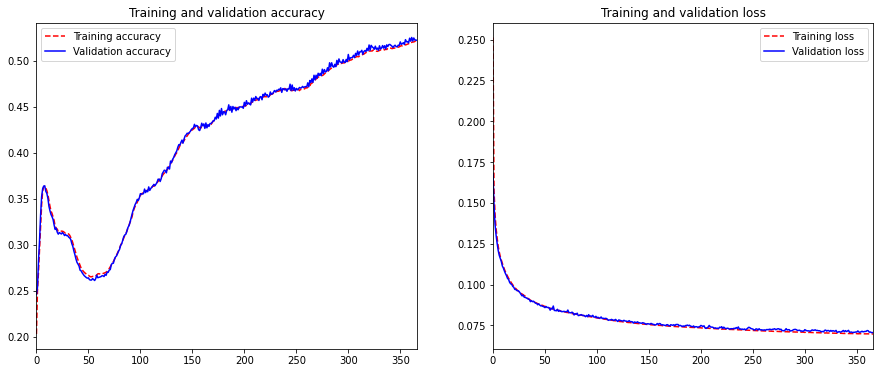

In [7]:
#train
epochs= 500
autoencoder_train = autoencoder.fit(X_train, X_train, epochs=epochs,verbose=1,
    validation_data=(X_test, X_test), callbacks=[earlystop])

#Model evaluation
scores = autoencoder.evaluate(X_train, X_train, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))

# #save weights & model
#autoencoder.save_weights('saved_models/autoencoder25_weights.h5')
autoencoder.save('saved_models/autoencoder200.h5py')

accuracy = autoencoder_train.history['accuracy']
val_accuracy = autoencoder_train.history['val_accuracy']
loss = autoencoder_train.history['loss']
val_loss = autoencoder_train.history['val_loss']
epochs = range(len(accuracy))
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(15,6))
ax1.plot(epochs, accuracy, 'r--', label='Training accuracy')
ax1.plot(epochs, val_accuracy, 'b', label='Validation accuracy')
ax1.set_title('Training and validation accuracy')
ax1.legend()
ax2.plot(epochs, loss, 'r--', label='Training loss')
ax2.plot(epochs, val_loss, 'b', label='Validation loss')
ax2.set_title('Training and validation loss')
ax2.legend()
plt.savefig('accuracy_loss_5.pdf')
plt.show()

[100, 89, 956]


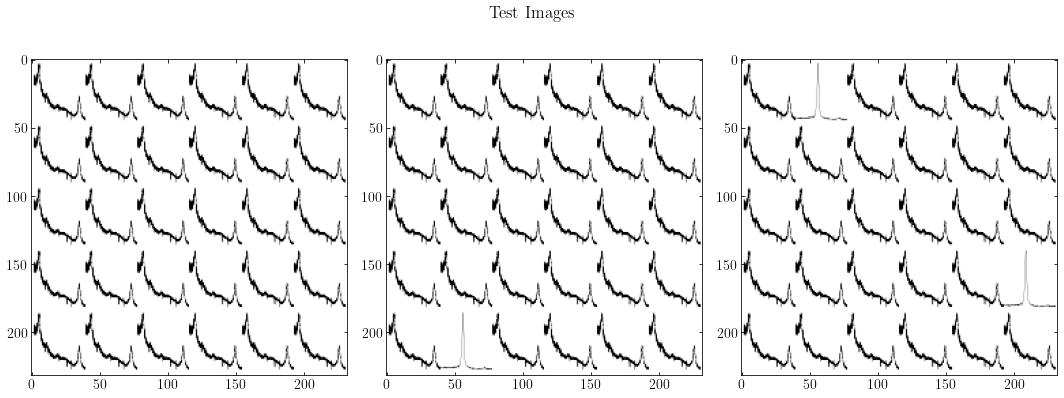

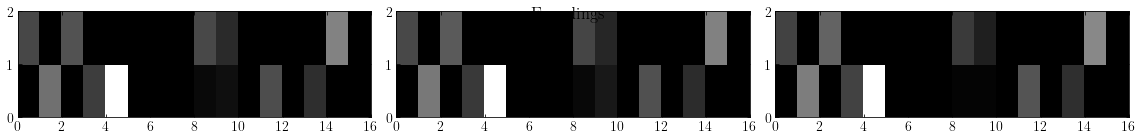

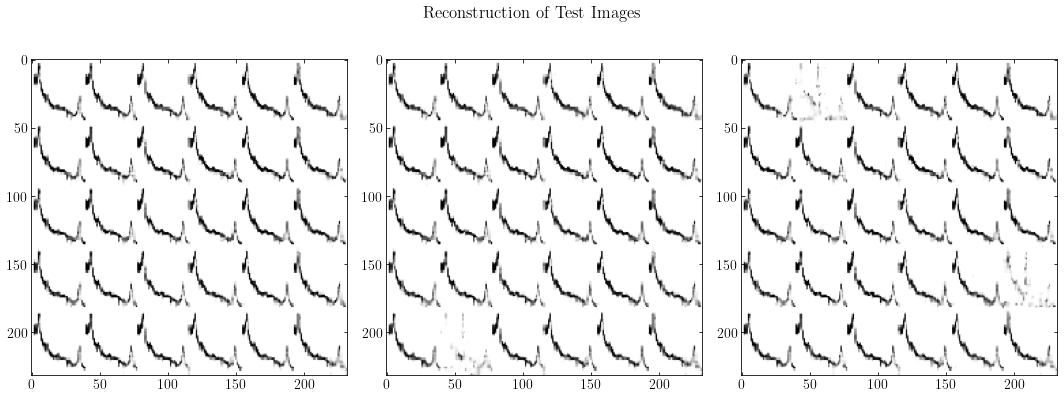

In [58]:
#visually inspect reconstructions to test accuracy

#create data set of our 3 different images
small = create_dataset("test")
small=np.array(small)

#pick random images
ncols=3
# pred= autoencoder.predict(small)
# idx = [0,1,2]

#pred = autoencoder.predict(X_train)
#encodings = encoder.predict(X_train)
#idx = np.random.choice(len(X_train), size=ncols)
idx = [100, 89, 956]
print(idx)

if "setup_text_plots" not in globals():
    from astroML.plotting import setup_text_plots
setup_text_plots(fontsize=14, usetex=True)

fig, ax = plt.subplots(nrows=1, ncols=ncols, figsize=(15,6))
fig.suptitle('Test Images')
for i, num in enumerate(idx):
    ax[i].imshow(X_train[num, ..., 0], cmap='gray')
    #adjust_spines(ax[i], [])
fig.tight_layout()
fig.subplots_adjust(top=0.95)
#plt.savefig('test_images_5.pdf')

fig, ax = plt.subplots(ncols=ncols, figsize=(16, 2))
fig.suptitle('Encodings')
for i, num in enumerate(idx):
    #code = encoder.predict(X_train[idx])[0]
    code = encodings[num]
    ax[i].imshow(code.reshape([-1, code.shape[-1]//2]), cmap='gray')
    #ax[i].pcolor(code.reshape([-1, code.shape[-1]//2]), cmap='gray')
    #adjust_spines(ax[i], [])
fig.tight_layout()
fig.subplots_adjust(top=0.95)
#plt.savefig('encodings_5.pdf')

fig, ax = plt.subplots(nrows=1, ncols=ncols, figsize=(15,6))
fig.suptitle('Reconstruction of Test Images')
for i, num in enumerate(idx):
    ax[i].imshow(pred[num, ..., 0], cmap='gray')
    #adjust_spines(ax[i], [])
fig.tight_layout()
fig.subplots_adjust(top=0.95)
#plt.savefig('reconstructions_5.pdf')
    
plt.show()


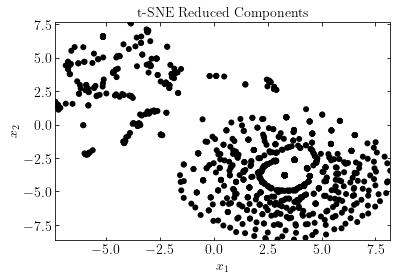

In [78]:
# t-SNE
from sklearn.manifold import TSNE
#try learning rates between 5 and 50?
tsne = TSNE(n_components=2,learning_rate=300, perplexity=30, n_iter=1000)
X_reduced = tsne.fit_transform(encodings)

#or
#tsne_em = TSNE(n_components=2, perplexity=30.0, n_iter=1000, verbose=1).fit_transform(encodings)

plt.title('t-SNE Reduced Components')
plt.xlabel("$x_1$")
plt.ylabel("$x_2$")
plt.scatter(X_reduced[:,0], X_reduced[:,1], c="k", edgecolor="None")
#plt.colorbar()
plt.savefig('tsne_5_lr300_perp30_iter1000.pdf')

In [106]:
def plot_dbscan(dbscan, X, size, show_xlabels=True, show_ylabels=True):
    core_mask = np.zeros_like(dbscan.labels_, dtype=bool)
    core_mask[dbscan.core_sample_indices_] = True
    anomalies_mask = dbscan.labels_ == -1
    non_core_mask = ~(core_mask | anomalies_mask)

    cores = dbscan.components_
    anomalies = X[anomalies_mask]
    non_cores = X[non_core_mask]
    
    plt.scatter(cores[:, 0], cores[:, 1],
                c=dbscan.labels_[core_mask], marker='o', s=size, cmap="Paired")
    plt.scatter(cores[:, 0], cores[:, 1], marker='*', s=20, c=dbscan.labels_[core_mask])
    plt.scatter(anomalies[:, 0], anomalies[:, 1],
                c="r", marker="x", s=100)
    plt.scatter(non_cores[:, 0], non_cores[:, 1], c=dbscan.labels_[non_core_mask], marker=".")
    if show_xlabels:
        plt.xlabel("$x_1$", fontsize=14)
    else:
        plt.tick_params(labelbottom=False)
    if show_ylabels:
        plt.ylabel("$x_2$", fontsize=14, rotation=0)
    else:
        plt.tick_params(labelleft=False)
    title = "DBSCAN with eps=" + str(np.round(dbscan.eps,2)) +", min_samples=" + str(dbscan.min_samples)
    #title = "DBSCAN with eps=%s, min_samples=%s" % (str(np.round(dbscan.eps,2)), dbscan.min_samples)
#     print(title)
#     plt.title(title, fontsize=14)

    print("Anomalies:", anomalies)
    plt.show()

In [ ]:
#find optimal number of clusters for DBSCAN
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.cluster import KMeans
range_n_clusters = range(2,len(X_reduced))

best_n_clusters, best_score = 0,0
 
for n_clusters in range_n_clusters:
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(X_reduced)
    
    #print("Cluster_labels", cluster_labels)
    
    #silhouette score gives info on density and separation of formed clusters
    silhouette_avg = silhouette_score(X_reduced, cluster_labels)
    
    if silhouette_avg > best_score:
        best_score = silhouette_avg
        best_n_clusters = n_clusters
print("Best_n_clusters", best_n_clusters)

In [ ]:
#assume 1 cluster (just similar spectra - so dissimilar ones are outliers)

#find best hyperparameters for DBSCAN (min_samples and eps)
from sklearn.cluster import DBSCAN

#assume min_samples = best_n_clusters to find optimal eps value 

range_eps = np.arange(0.01, 1, 0.01)
best_eps, best_silhouette_score = 0, 0
for eps in range_eps:
    db = DBSCAN(eps=eps, min_samples=best_n_clusters).fit(X_reduced)
    core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
    core_samples_mask[db.core_sample_indices_] = True
    labels = db.labels_
    silhouette_avg = silhouette_score(X_reduced, labels)
    
    #highest silhouette score gives us best eps value
    if silhouette_avg > best_silhouette_score:
        best_silhouette_score = silhouette_avg
        best_eps = eps
    
#now try various min_samples using this best_eps
min_samples = range(1, 500)
best_min_samples = 0
for n_samples in min_samples:
    db = DBSCAN(eps=best_eps, min_samples=n_samples).fit(X_reduced)
    core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
    core_samples_mask[db.core_sample_indices_] = True
    
    #ignore label -1 since that is outliers
    labels = set([label for label in db.labels_ if label >= 0])

    #if len of set(labels) == best_n_clusters, min_samples value is good
    if len(set(labels)) == best_n_clusters:
        best_min_samples = n_samples
        
print("Best_eps", best_eps, "best_min_samples", best_min_samples)

In [ ]:
#compute DBSCAN and plot
from sklearn.cluster import DBSCAN
db = DBSCAN(eps=best_eps, min_samples=best_min_samples).fit(X_reduced)

#or
#get_clusters = DBSCAN(eps=3, min_samples=10).fit_predict(tsne_em)
# check unique clusters
# -1 value represents noisy points could not assigned to any cluster

plt.figure(figsize=(10, 10))
plot_dbscan(db, X_reduced, size=100)

In [57]:
#finetune hyperparameters with RandomizedSearchCV

from keras.wrappers.scikit_learn import KerasClassifier
model = KerasClassifier(build_fn = create_model())

#define parameters to test
params = {'activation': ['relu', 'leaky_relu', 'tanh'], 'batch_size':[32,128,256],
         'epochs': [50, 100, 200], 'learning_rate': [0.1, 0.01, 0.001]}

#create randomized search CV object
random_search = RandomizedSearchCV(model, param_distributions=params, cv=KFold(3))

#fit random_search
history = random_search.fit(X_train, X_train)

#print score
score = random_search.evaluate(X_train, X_train)
print(score)

input_2 (3, 232, 232, 3) -> Skipped. First dimension is not 1.
conv2d_10 (3, 232, 232, 12) -> Skipped. First dimension is not 1.
max_pooling2d_4 (3, 116, 116, 12) -> Skipped. First dimension is not 1.
conv2d_11 (3, 116, 116, 8) -> Skipped. First dimension is not 1.
max_pooling2d_5 (3, 29, 29, 8) -> Skipped. First dimension is not 1.
flatten_2 (3, 6728) -> Skipped. First dimension is not 1.
bottleneck (3, 32) -> Skipped. First dimension is not 1.


In [ ]:
#now search for best loss function and optimizer 
params = dict(loss=["mean_squared_error", "sgd", "binary_crossentropy"], optimizer=["rmsprop", "adam", "adamax"])